In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from PIL import ImageDraw
from random import randint
from torchvision.models import resnet34, vgg16_bn, resnet50

In [3]:
path = untar_data(URLs.IMAGEWOOF); path.ls()

[PosixPath('/home/jupyter/.fastai/data/imagewoof/models'),
 PosixPath('/home/jupyter/.fastai/data/imagewoof/val'),
 PosixPath('/home/jupyter/.fastai/data/imagewoof/train')]

In [4]:
path_img = path/'train'

In [5]:
size = 64
bs = 64
size, bs

(64, 64)

In [6]:
src = ImageImageList.from_folder(path).split_by_folder(valid='val')

In [7]:
class TfmPixelXOnly(TfmPixel):
    def __call__(self, *args, **kwargs):
        kwargs.pop('use_on_y', None)
        return super().__call__(*args, use_on_y=False, **kwargs)

In [8]:
def _draw_box(x):
    xy = x.shape[1:]
    bw, bh = randint(int(xy[0]*0.1), int(xy[0]*0.2)), randint(int(xy[1]*0.1), int(xy[1]*0.3))
    bx1, by1 = randint(0, xy[0]-bw), randint(0, xy[1]-bh)
    x[:, bx1:bx1+bh, by1:by1+bw] = 0
    return x

def _rand_boxes(x):
    for _ in range(randint(15, 20)): x = _draw_box(x)
    return x
rand_boxes = TfmPixelXOnly(_rand_boxes)

In [9]:
x_tfm, y_tfm = get_transforms(max_zoom=0.2)
y_tfm = x_tfm
x_tfm.append(rand_boxes())

In [10]:
data = (src
        .label_from_func(lambda x: x)
        .transform((x_tfm, x_tfm), tfm_y=True, size=size)
        .databunch(bs=bs).normalize(imagenet_stats, do_y=True)
       )

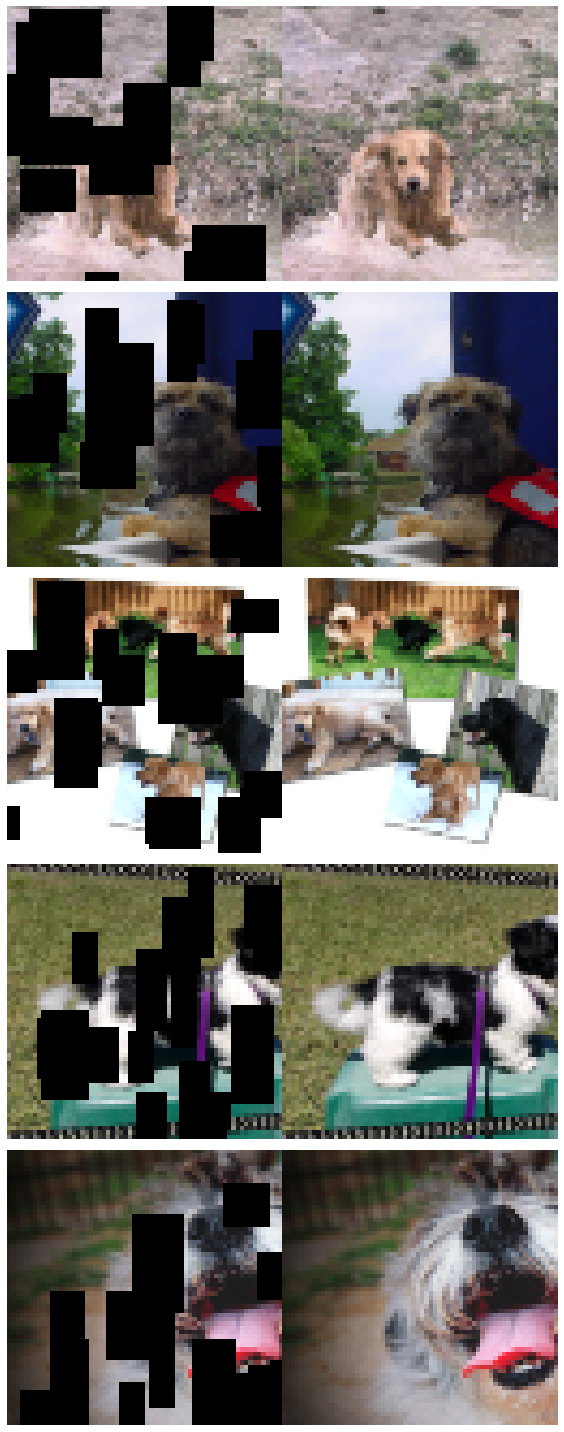

In [11]:
data.show_batch()

## Feature loss

In [12]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [13]:
base_loss = F.l1_loss

In [14]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layers, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = layers
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layers))
              ] + [f'gram_{i}' for i in range(len(layers))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [15]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [16]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
layers = [vgg_m[i] for i in blocks]

In [17]:
feat_loss = FeatureLoss(vgg_m, layers=layers[2:5], layer_wgts=[5, 15, 2])

## Train

In [18]:
learn = None
gc.collect()

22250

In [19]:
learn = unet_learner(data, models.resnet34, wd=1e-3, loss_func=feat_loss,
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Spectral,
                     self_attention=True, y_range=(-3, 3)).to_fp16()

In [20]:
# learn.load('res50-vgg-stage-2-128_3')
# learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


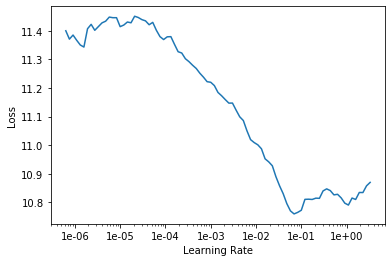

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-3

In [23]:
learn.freeze()
learn.fit_one_cycle(3, lr, pct_start=0.8)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,9.743036,9.142399,0.460698,0.372776,0.569324,0.455173,1.245383,3.368822,2.670223,01:06
1,8.293427,8.137493,0.351943,0.313908,0.481799,0.408520,1.017006,2.928357,2.635961,01:06
2,7.626346,7.589066,0.318461,0.291856,0.449945,0.380102,0.927650,2.743854,2.477196,01:04


In [23]:
learn.save('res50-vgg-stage-1-128_1')

In [0]:
learn.load('res50-vgg-stage-1-128')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


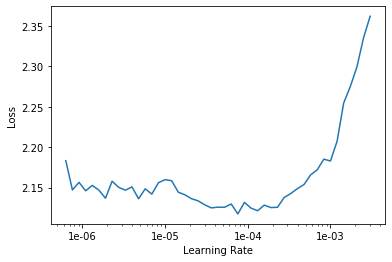

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(7, slice(1e-5, 1e-3), pct_start=0.3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.998421,1.958764,0.098507,0.104711,0.164262,0.130833,0.235765,0.603401,0.621284,05:12
1,2.085902,2.108834,0.112490,0.113149,0.177899,0.140674,0.251989,0.649589,0.663043,05:11
2,2.054880,2.078129,0.114585,0.111076,0.175202,0.138667,0.247202,0.633357,0.658039,05:11
3,2.042886,2.005546,0.097352,0.105978,0.166219,0.135746,0.237856,0.611361,0.651034,05:12
4,1.976170,1.994097,0.097364,0.105851,0.166953,0.133734,0.236829,0.616329,0.637039,05:12
5,1.928973,1.936380,0.094014,0.101544,0.160697,0.131561,0.227904,0.594714,0.625947,05:12
6,1.947899,1.886156,0.090172,0.099759,0.157371,0.126914,0.225041,0.582130,0.604769,05:12


In [0]:
learn.save('res50-vgg-stage-2-128_3')

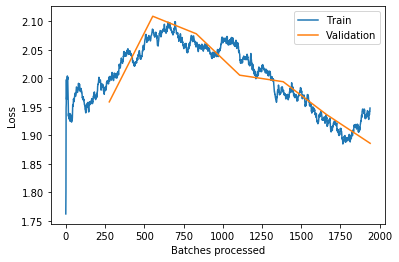

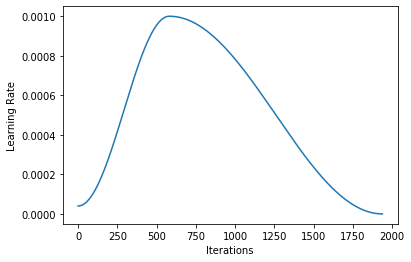

In [0]:
learn.recorder.plot_losses(); learn.recorder.plot_lr()

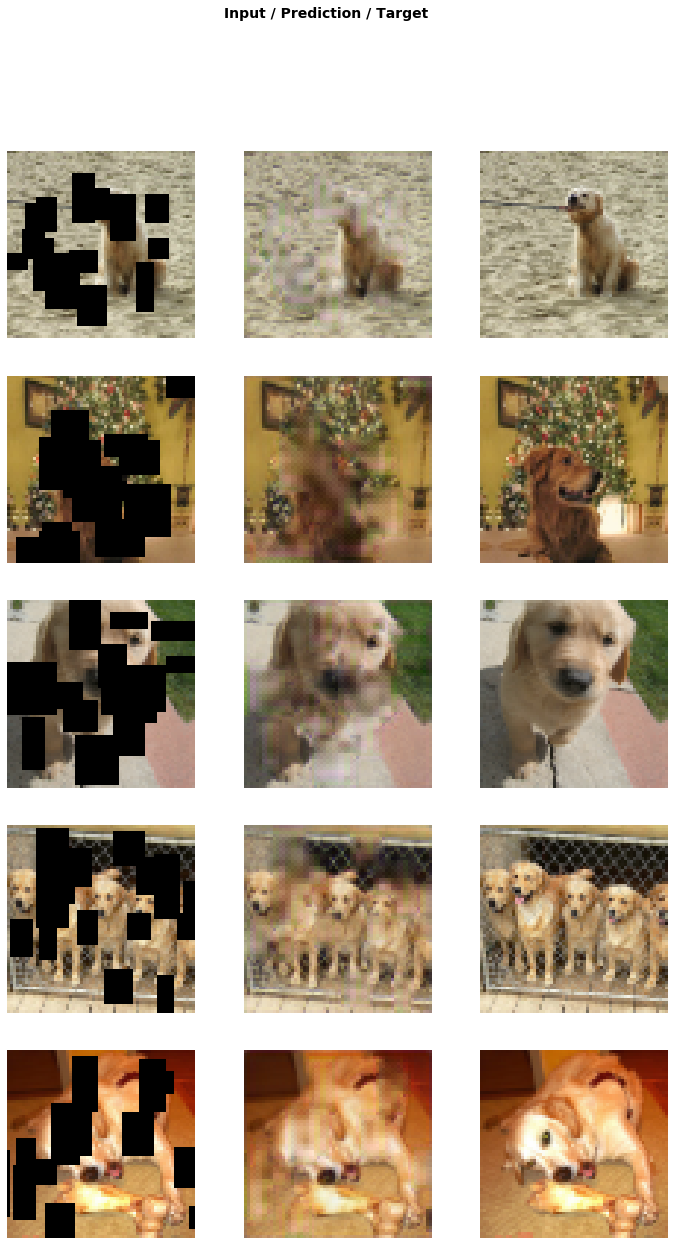

In [24]:
learn.show_results(ds_type=DatasetType.Valid)

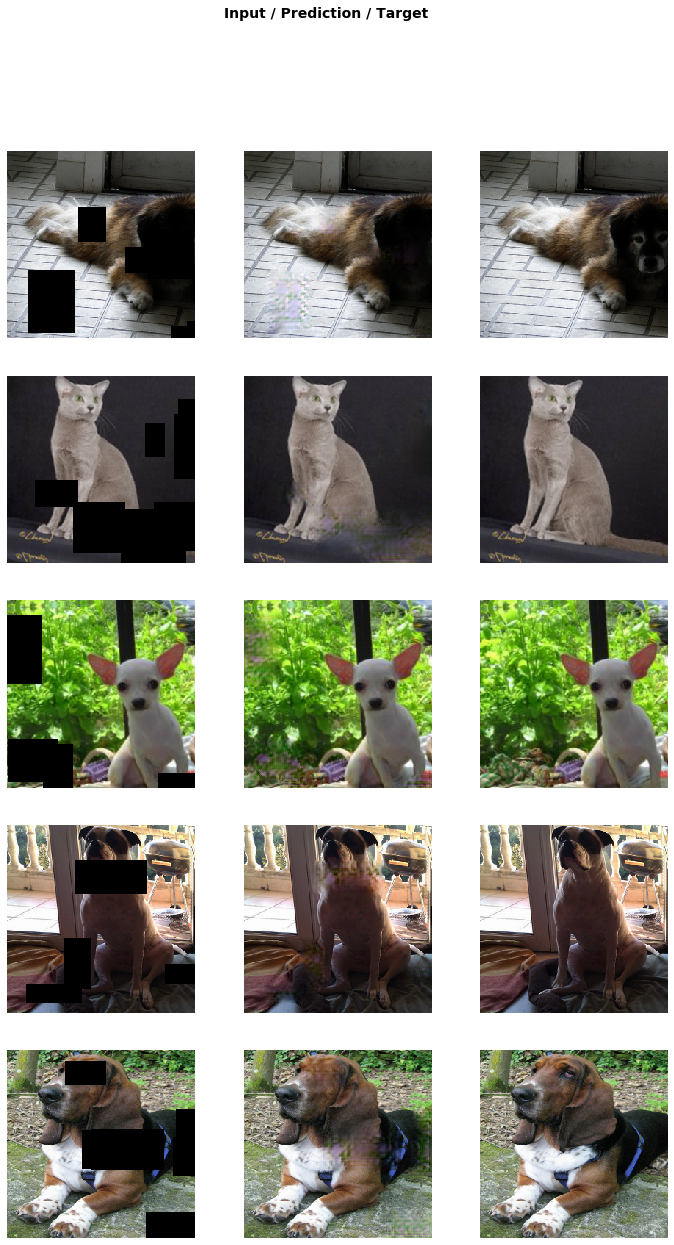

In [0]:
learn.show_results(ds_type=DatasetType.Train)